# Test for Catastrophic Forgetting

Model: MLP
Loss: MSE
Method: First 5 classes [0, 1, 2, 3, 4] are trained first, then the remaining classes [5, 6, 7, 8, 9] are trained.

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
class FilteredFashionMNIST(Dataset):
    def __init__(self, dataset, target_classes):
        self.data = []
        self.targets = []
        for i in range(len(dataset)):
            img, target = dataset[i]
            if target in target_classes:
                self.data.append(img)
                self.targets.append(target)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


In [5]:
# 抽出したいターゲットクラスのリスト
target_classes1 = [0, 1, 2, 3, 4]
target_classes2 = [5, 6, 7, 8, 9]

# ターゲットクラス番号がリストに含まれるデータのみを抽出
training_data1 = FilteredFashionMNIST(training_data, target_classes1)
training_data2 = FilteredFashionMNIST(training_data, target_classes2)

test_data1 = FilteredFashionMNIST(test_data, target_classes1)
test_data2 = FilteredFashionMNIST(test_data, target_classes2)

# 抽出されたデータセットの確認
print(f"元の訓練データセットのサイズ: {len(training_data)}")
print(f"抽出後の訓練データセット１のサイズ: {len(training_data1)}")
print(f"抽出後の訓練データセット２のサイズ: {len(training_data2)}")

print(f"元のテストデータセットのサイズ: {len(test_data)}")
print(f"抽出後のテストデータセット１のサイズ: {len(test_data1)}")
print(f"抽出後のテストデータセット２のサイズ: {len(test_data2)}")

# 抽出されたデータセットの最初の要素のクラス番号を確認
print(f"抽出後の訓練データセット１の最初の要素のクラス番号: {training_data1[0][1]}")
print(f"抽出後の訓練データセット２の最初の要素のクラス番号: {training_data2[0][1]}")
print(f"抽出後のテストデータセット１の最初の要素のクラス番号: {test_data1[0][1]}")
print(f"抽出後のテストデータセット２の最初の要素のクラス番号: {test_data2[0][1]}")



元の訓練データセットのサイズ: 60000
抽出後の訓練データセット１のサイズ: 30000
抽出後の訓練データセット２のサイズ: 30000
元のテストデータセットのサイズ: 10000
抽出後のテストデータセット１のサイズ: 5000
抽出後のテストデータセット２のサイズ: 5000
抽出後の訓練データセット１の最初の要素のクラス番号: 0
抽出後の訓練データセット２の最初の要素のクラス番号: 9
抽出後のテストデータセット１の最初の要素のクラス番号: 2
抽出後のテストデータセット２の最初の要素のクラス番号: 9


In [6]:
batch_size = 64

# Create data loaders.
train1_dataloader = DataLoader(training_data1, batch_size=batch_size)
train2_dataloader = DataLoader(training_data2, batch_size=batch_size)
test1_dataloader = DataLoader(test_data1, batch_size=batch_size)
test2_dataloader = DataLoader(test_data2, batch_size=batch_size)

for X, y in test1_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Using cuda device


In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = nn.functional.one_hot(y, num_classes=10).float()
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

#        if batch % 100 == 0:
#            loss, current = loss.item(), (batch + 1) * len(X)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def eval(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = nn.functional.one_hot(y, num_classes=10).float()
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
#    print(f"\t Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    
    return correct

In [10]:
# model, loss_fn, optimizer

model = NeuralNetwork().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
# Training the model parameters with the training data1 then training data2

epochs = 10

train1_accuracy = []
train2_accuracy = []
test1_accuracy = []
test2_accuracy = []

print("Train1:")
for t in range(epochs):
#    print(f"Epoch {t+1}\n-------------------------------")
    train(train1_dataloader, model, loss_fn, optimizer)
    train1_acc = eval(train1_dataloader, model, loss_fn)
    train2_acc = eval(train2_dataloader, model, loss_fn)
    test1_acc = eval(test1_dataloader, model, loss_fn)
    test2_acc = eval(test2_dataloader, model, loss_fn)
    train1_accuracy.append(train1_acc)
    train2_accuracy.append(train2_acc)
    test1_accuracy.append(test1_acc)
    test2_accuracy.append(test2_acc)
#    print(f"Epoch {t+1} train1_accuracy: {train1_acc}, train2_accuracy: {train2_acc}, test1_accuracy: {test1_acc}, test2_accuracy: {test2_acc}")
    print("Epoch %d train1_accuracy: %.2f, train2_accuracy: %.2f, test1_accuracy: %.2f, test2_accuracy: %.2f" % (t+1, train1_acc, train2_acc, test1_acc, test2_acc))
print("Done!")

print("Train2:")
for t in range(epochs):
#    print(f"Epoch {t+1}\n-------------------------------")
    train(train2_dataloader, model, loss_fn, optimizer)
    train1_acc = eval(train1_dataloader, model, loss_fn)
    train2_acc = eval(train2_dataloader, model, loss_fn)
    test1_acc = eval(test1_dataloader, model, loss_fn)
    test2_acc = eval(test2_dataloader, model, loss_fn)
    train1_accuracy.append(train1_acc)
    train2_accuracy.append(train2_acc)
    test1_accuracy.append(test1_acc)
    test2_accuracy.append(test2_acc)
#    print(f"Epoch {t+1} train1_accuracy: {train1_acc}, train2_accuracy: {train2_acc}, test1_accuracy: {test1_acc}, test2_accuracy: {test2_acc}")
    print("Epoch %d train1_accuracy: %.2f, train2_accuracy: %.2f, test1_accuracy: %.2f, test2_accuracy: %.2f" % (t+1, train1_acc, train2_acc, test1_acc, test2_acc))
print("Done!")


Train1:
Epoch 1 train1_accuracy: 0.38, train2_accuracy: 0.00, test1_accuracy: 0.38, test2_accuracy: 0.00
Epoch 2 train1_accuracy: 0.51, train2_accuracy: 0.00, test1_accuracy: 0.50, test2_accuracy: 0.00
Epoch 3 train1_accuracy: 0.61, train2_accuracy: 0.00, test1_accuracy: 0.60, test2_accuracy: 0.00
Epoch 4 train1_accuracy: 0.65, train2_accuracy: 0.00, test1_accuracy: 0.64, test2_accuracy: 0.00
Epoch 5 train1_accuracy: 0.68, train2_accuracy: 0.00, test1_accuracy: 0.67, test2_accuracy: 0.00
Epoch 6 train1_accuracy: 0.70, train2_accuracy: 0.00, test1_accuracy: 0.69, test2_accuracy: 0.00
Epoch 7 train1_accuracy: 0.72, train2_accuracy: 0.00, test1_accuracy: 0.70, test2_accuracy: 0.00
Epoch 8 train1_accuracy: 0.73, train2_accuracy: 0.00, test1_accuracy: 0.72, test2_accuracy: 0.00
Epoch 9 train1_accuracy: 0.74, train2_accuracy: 0.00, test1_accuracy: 0.73, test2_accuracy: 0.00
Epoch 10 train1_accuracy: 0.75, train2_accuracy: 0.00, test1_accuracy: 0.74, test2_accuracy: 0.00
Done!
Train2:
Epoch 1

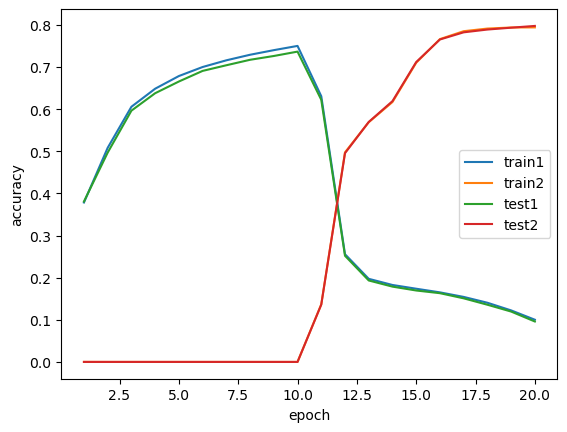

In [12]:
# Plot the learning curve

import matplotlib.pyplot as plt

x_epoch = range(1, 2*epochs+1)
plt.plot(x_epoch, train1_accuracy, label="train1")
plt.plot(x_epoch, train2_accuracy, label="train2")
plt.plot(x_epoch, test1_accuracy, label="test1")
plt.plot(x_epoch, test2_accuracy, label="test2")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show() 